In [313]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [177]:
df = pd.read_csv('cleaned_data.csv')

In [233]:
df.head()

,model,model_year,milage_miles,engine,ext_col,int_col,accident,clean_title,price_$,horsepower,engine_size_L,car_age,accident_reported,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,brand_Buick,brand_Cadillac,brand_Chevrolet,brand_Chrysler,brand_Dodge,brand_FIAT,brand_Ferrari,brand_Ford,brand_GMC,brand_Genesis,brand_Honda,brand_Hummer,brand_Hyundai,brand_INFINITI,brand_Jaguar,brand_Jeep,brand_Karma,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_Lincoln,brand_Lotus,brand_Lucid,brand_MINI,brand_Maserati,brand_Maybach,brand_Mazda,brand_McLaren,brand_Mercedes-Benz,brand_Mercury,brand_Mitsubishi,brand_Nissan,brand_Plymouth,brand_Polestar,brand_Pontiac,brand_Porsche,brand_RAM,brand_Rivian,brand_Rolls-Royce,brand_Saab,...,transmission_10-Speed A/T,transmission_10-Speed Automatic,transmission_10-Speed Automatic with Overdrive,transmission_2,transmission_2-Speed A/T,transmission_2-Speed Automatic,transmission_4-Speed A/T,transmission_4-Speed Automatic,transmission_5-Speed A/T,transmission_5-Speed Automatic,transmission_5-Speed M/T,transmission_6 Speed At/Mt,transmission_6 Speed Mt,transmission_6-Speed,transmission_6-Speed A/T,transmission_6-Speed Automatic,transmission_6-Speed Automatic with Auto-Shift,transmission_6-Speed Electronically Controlled Automatic with O,transmission_6-Speed M/T,transmission_6-Speed Manual,transmission_7-Speed,transmission_7-Speed A/T,transmission_7-Speed Automatic,transmission_7-Speed Automatic with Auto-Shift,transmission_7-Speed DCT Automatic,transmission_7-Speed M/T,transmission_7-Speed Manual,transmission_8-SPEED A/T,transmission_8-SPEED AT,transmission_8-Speed A/T,transmission_8-Speed Automatic,transmission_8-Speed Automatic with Auto-Shift,transmission_8-Speed Manual,transmission_9-Speed A/T,transmission_9-Speed Automatic,transmission_9-Speed Automatic with Auto-Shift,transmission_A/T,"transmission_Auto, 6-Spd w/CmdShft",transmission_Automatic,transmission_Automatic CVT,"transmission_Automatic, 10-Spd","transmission_Automatic, 7-Spd S tronic Dual-Clutch","transmission_Automatic, 8-Spd","transmission_Automatic, 8-Spd Dual-Clutch","transmission_Automatic, 8-Spd M STEPTRONIC w/Drivelogic, Sport & Manual Modes","transmission_Automatic, 8-Spd PDK Dual-Clutch","transmission_Automatic, 8-Spd Sport w/Sport & Manual Modes","transmission_Automatic, 9-Spd 9G-Tronic",transmission_CVT Transmission,transmission_CVT-F,transmission_F,transmission_M/T,transmission_Manual,"transmission_Manual, 6-Spd",transmission_SCHEDULED FOR OR IN PRODUCTION,transmission_Single-Speed Fixed Gear,transmission_Transmission Overdrive Switch,transmission_Transmission w/Dual Shift Mode,transmission_Variable,transmission_–
0,Utility Police Interceptor Base,2013,51000,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,Black,Black,At least 1 accident or damage reported,1,10300,300.0,3.7,12,1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Palisade SEL,2021,34742,3.8L V6 24V GDI DOHC,Moonlight Cloud,Gray,At least 1 accident or damage reported,1,38005,310.0,3.8,4,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [181]:
def extract_hp(engine_text):
    if pd.isnull(engine_text):
        return None
    match = re.search(r"(\d+(\.\d+)?)HP", engine_text)
    return float(match.group(1)) if match else None
    
df['horsepower'] = df['engine'].apply(extract_hp)


In [183]:
def extract_engine_size(engine_text):
    if pd.isnull(engine_text):
        return None
    match = re.search(r"(\d+(\.\d+)?)L", engine_text)
    return float(match.group(1)) if match else None

df['engine_size_L'] = df['engine'].apply(extract_engine_size)

In [203]:
df['horsepower'].isnull().sum()

0

In [201]:
df['horsepower'].fillna(df['horsepower'].median(), inplace=True)


C:\Users\Pratik\AppData\Local\Temp\ipykernel_18208\3730510594.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['horsepower'].fillna(df['horsepower'].median(), inplace=True)


In [197]:
df['horsepower'] = df.groupby('engine_size_L')['horsepower'].transform(
    lambda x: x.fillna(x.median())
)

In [211]:
df['engine_size_L'].isnull().sum()

0

In [207]:
#Fill using brand-wise median (fallback)
df['engine_size_L'] = df.groupby('brand')['engine_size_L'].transform(
    lambda x: x.fillna(x.median())
)

In [209]:
df['engine_size_L'].fillna(df['engine_size_L'].median(), inplace=True)

C:\Users\Pratik\AppData\Local\Temp\ipykernel_18208\2528581908.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['engine_size_L'].fillna(df['engine_size_L'].median(), inplace=True)


In [213]:
#convert model_year to car_age

current_year = datetime.now().year
df['car_age'] = current_year - df['model_year']


In [215]:
#convert accident column to binary

df['accident_reported'] = df['accident'].apply(lambda x : 0 if 'None reported' in str(x) else 1)

In [217]:
#convert clean title to binary
df['clean_title'] = df['clean_title'].map({'Yes':1, 'No':0})

In [227]:
print(df['fuel_type'].unique())


['FlexFuel' 'Gasoline' 'Hybrid' 'other' 'Diesel']


In [225]:
# Define mapping
fuel_mapping = {
    'FlexFuel': 'FlexFuel',
    'Gasoline': 'Gasoline',
    'Diesel': 'Diesel',
    'Hybrid': 'Hybrid',
    'other': 'other',
    np.nan: 'other'
}

# Apply mapping
df['fuel_type'] = df['fuel_type'].map(fuel_mapping)

In [97]:
#Encoding Categorical columns

In [231]:
#one-hot encoding

cols_to_encode = ['brand','fuel_type','transmission']

df = pd.get_dummies(df,columns=cols_to_encode,drop_first=True)

In [235]:
df.columns

Index(['model', 'model_year', 'milage_miles', 'engine', 'ext_col', 'int_col',
       'accident', 'clean_title', 'price_$', 'horsepower',
       ...
       'transmission_F', 'transmission_M/T', 'transmission_Manual',
       'transmission_Manual, 6-Spd',
       'transmission_SCHEDULED FOR OR IN PRODUCTION',
       'transmission_Single-Speed Fixed Gear',
       'transmission_Transmission Overdrive Switch',
       'transmission_Transmission w/Dual Shift Mode', 'transmission_Variable',
       'transmission_–'],
      dtype='object', length=134)

In [241]:
df.dtypes

model                                          object
model_year                                      int64
milage_miles                                    int64
engine                                         object
ext_col                                        object
                                                ...  
transmission_Single-Speed Fixed Gear            int32
transmission_Transmission Overdrive Switch      int32
transmission_Transmission w/Dual Shift Mode     int32
transmission_Variable                           int32
transmission_–                                  int32
Length: 134, dtype: object

In [239]:
# Convert all boolean columns to integers
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)


In [243]:
cols_to_drop = ['model_year','engine','accident','model','ext_col','int_col']
df.drop(columns = [col for col in cols_to_drop if col in df.columns],inplace = True)

In [245]:
df.head()

,milage_miles,clean_title,price_$,horsepower,engine_size_L,car_age,accident_reported,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,brand_Buick,brand_Cadillac,brand_Chevrolet,brand_Chrysler,brand_Dodge,brand_FIAT,brand_Ferrari,brand_Ford,brand_GMC,brand_Genesis,brand_Honda,brand_Hummer,brand_Hyundai,brand_INFINITI,brand_Jaguar,brand_Jeep,brand_Karma,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_Lincoln,brand_Lotus,brand_Lucid,brand_MINI,brand_Maserati,brand_Maybach,brand_Mazda,brand_McLaren,brand_Mercedes-Benz,brand_Mercury,brand_Mitsubishi,brand_Nissan,brand_Plymouth,brand_Polestar,brand_Pontiac,brand_Porsche,brand_RAM,brand_Rivian,brand_Rolls-Royce,brand_Saab,brand_Saturn,brand_Scion,brand_Subaru,brand_Suzuki,brand_Tesla,brand_Toyota,...,transmission_10-Speed A/T,transmission_10-Speed Automatic,transmission_10-Speed Automatic with Overdrive,transmission_2,transmission_2-Speed A/T,transmission_2-Speed Automatic,transmission_4-Speed A/T,transmission_4-Speed Automatic,transmission_5-Speed A/T,transmission_5-Speed Automatic,transmission_5-Speed M/T,transmission_6 Speed At/Mt,transmission_6 Speed Mt,transmission_6-Speed,transmission_6-Speed A/T,transmission_6-Speed Automatic,transmission_6-Speed Automatic with Auto-Shift,transmission_6-Speed Electronically Controlled Automatic with O,transmission_6-Speed M/T,transmission_6-Speed Manual,transmission_7-Speed,transmission_7-Speed A/T,transmission_7-Speed Automatic,transmission_7-Speed Automatic with Auto-Shift,transmission_7-Speed DCT Automatic,transmission_7-Speed M/T,transmission_7-Speed Manual,transmission_8-SPEED A/T,transmission_8-SPEED AT,transmission_8-Speed A/T,transmission_8-Speed Automatic,transmission_8-Speed Automatic with Auto-Shift,transmission_8-Speed Manual,transmission_9-Speed A/T,transmission_9-Speed Automatic,transmission_9-Speed Automatic with Auto-Shift,transmission_A/T,"transmission_Auto, 6-Spd w/CmdShft",transmission_Automatic,transmission_Automatic CVT,"transmission_Automatic, 10-Spd","transmission_Automatic, 7-Spd S tronic Dual-Clutch","transmission_Automatic, 8-Spd","transmission_Automatic, 8-Spd Dual-Clutch","transmission_Automatic, 8-Spd M STEPTRONIC w/Drivelogic, Sport & Manual Modes","transmission_Automatic, 8-Spd PDK Dual-Clutch","transmission_Automatic, 8-Spd Sport w/Sport & Manual Modes","transmission_Automatic, 9-Spd 9G-Tronic",transmission_CVT Transmission,transmission_CVT-F,transmission_F,transmission_M/T,transmission_Manual,"transmission_Manual, 6-Spd",transmission_SCHEDULED FOR OR IN PRODUCTION,transmission_Single-Speed Fixed Gear,transmission_Transmission Overdrive Switch,transmission_Transmission w/Dual Shift Mode,transmission_Variable,transmission_–
0,51000,1,10300,300.0,3.7,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,34742,1,38005,310.0,3.8,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22372,0,54598,310.0,3.5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,88900,1,15500,354.0,3.5,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9835,0,34999,310.0,2.0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [247]:
print("Remaining columns:\n", df.columns)
print("\nData types:\n", df.dtypes)


Remaining columns:
 Index(['milage_miles', 'clean_title', 'price_$', 'horsepower', 'engine_size_L',
       'car_age', 'accident_reported', 'brand_Alfa', 'brand_Aston',
       'brand_Audi',
       ...
       'transmission_F', 'transmission_M/T', 'transmission_Manual',
       'transmission_Manual, 6-Spd',
       'transmission_SCHEDULED FOR OR IN PRODUCTION',
       'transmission_Single-Speed Fixed Gear',
       'transmission_Transmission Overdrive Switch',
       'transmission_Transmission w/Dual Shift Mode', 'transmission_Variable',
       'transmission_–'],
      dtype='object', length=128)

Data types:
 milage_miles                                     int64
clean_title                                      int64
price_$                                          int64
horsepower                                     float64
engine_size_L                                  float64
                                                ...   
transmission_Single-Speed Fixed Gear             int32
tra

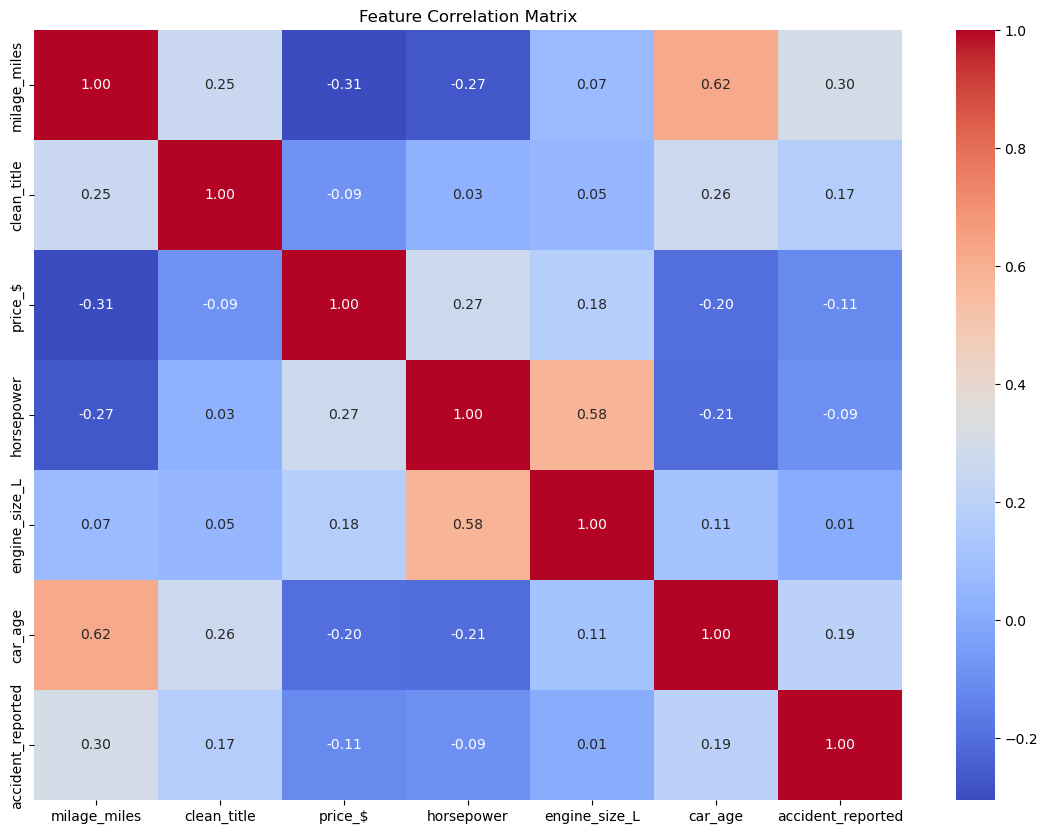

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


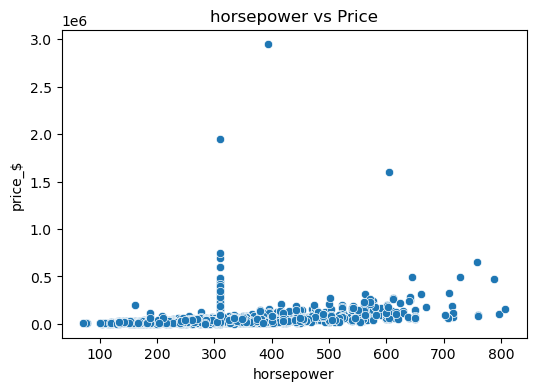

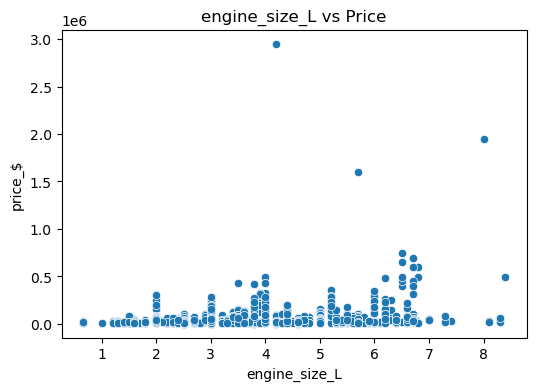

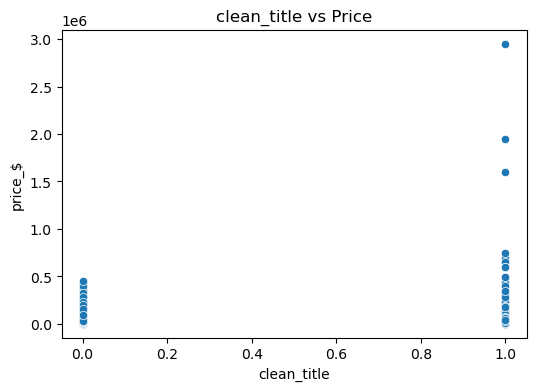

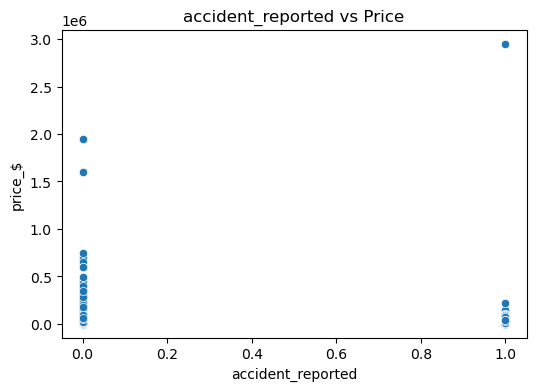

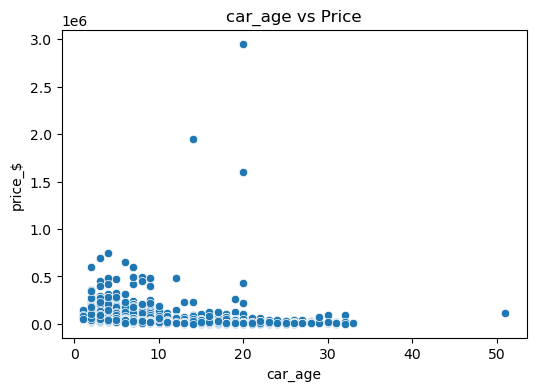

In [261]:
top_features = price_corr[1:6].index.tolist()

for feature in top_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df,x = feature,y='price_$')
    plt.title(f"{feature} vs Price")
    plt.show()

In [271]:
df.rename(columns={'price_$': 'price'},inplace=True)

In [277]:
#feature Importance
df.head()

,milage_miles,clean_title,price,horsepower,engine_size_L,car_age,accident_reported,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Bugatti,brand_Buick,brand_Cadillac,brand_Chevrolet,brand_Chrysler,brand_Dodge,brand_FIAT,brand_Ferrari,brand_Ford,brand_GMC,brand_Genesis,brand_Honda,brand_Hummer,brand_Hyundai,brand_INFINITI,brand_Jaguar,brand_Jeep,brand_Karma,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_Lincoln,brand_Lotus,brand_Lucid,brand_MINI,brand_Maserati,brand_Maybach,brand_Mazda,brand_McLaren,brand_Mercedes-Benz,brand_Mercury,brand_Mitsubishi,brand_Nissan,brand_Plymouth,brand_Polestar,brand_Pontiac,brand_Porsche,brand_RAM,brand_Rivian,brand_Rolls-Royce,brand_Saab,brand_Saturn,brand_Scion,brand_Subaru,brand_Suzuki,brand_Tesla,brand_Toyota,...,transmission_10-Speed A/T,transmission_10-Speed Automatic,transmission_10-Speed Automatic with Overdrive,transmission_2,transmission_2-Speed A/T,transmission_2-Speed Automatic,transmission_4-Speed A/T,transmission_4-Speed Automatic,transmission_5-Speed A/T,transmission_5-Speed Automatic,transmission_5-Speed M/T,transmission_6 Speed At/Mt,transmission_6 Speed Mt,transmission_6-Speed,transmission_6-Speed A/T,transmission_6-Speed Automatic,transmission_6-Speed Automatic with Auto-Shift,transmission_6-Speed Electronically Controlled Automatic with O,transmission_6-Speed M/T,transmission_6-Speed Manual,transmission_7-Speed,transmission_7-Speed A/T,transmission_7-Speed Automatic,transmission_7-Speed Automatic with Auto-Shift,transmission_7-Speed DCT Automatic,transmission_7-Speed M/T,transmission_7-Speed Manual,transmission_8-SPEED A/T,transmission_8-SPEED AT,transmission_8-Speed A/T,transmission_8-Speed Automatic,transmission_8-Speed Automatic with Auto-Shift,transmission_8-Speed Manual,transmission_9-Speed A/T,transmission_9-Speed Automatic,transmission_9-Speed Automatic with Auto-Shift,transmission_A/T,"transmission_Auto, 6-Spd w/CmdShft",transmission_Automatic,transmission_Automatic CVT,"transmission_Automatic, 10-Spd","transmission_Automatic, 7-Spd S tronic Dual-Clutch","transmission_Automatic, 8-Spd","transmission_Automatic, 8-Spd Dual-Clutch","transmission_Automatic, 8-Spd M STEPTRONIC w/Drivelogic, Sport & Manual Modes","transmission_Automatic, 8-Spd PDK Dual-Clutch","transmission_Automatic, 8-Spd Sport w/Sport & Manual Modes","transmission_Automatic, 9-Spd 9G-Tronic",transmission_CVT Transmission,transmission_CVT-F,transmission_F,transmission_M/T,transmission_Manual,"transmission_Manual, 6-Spd",transmission_SCHEDULED FOR OR IN PRODUCTION,transmission_Single-Speed Fixed Gear,transmission_Transmission Overdrive Switch,transmission_Transmission w/Dual Shift Mode,transmission_Variable,transmission_–
0,51000,1,10300,300.0,3.7,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,34742,1,38005,310.0,3.8,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22372,0,54598,310.0,3.5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,88900,1,15500,354.0,3.5,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9835,0,34999,310.0,2.0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [289]:
#using random forest regressor
X = df.drop(columns=['price'])   # Safer way to drop
y = df['price']

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [295]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [301]:
importances = rf.feature_importances_
feature_names = X.columns

importances_df = pd.DataFrame({
    'Feature':feature_names,
    'Importance': importances
})

importances_df = importances_df.sort_values(by="Importance",ascending=False)

print(importances_df.head(10))

                                           Feature  Importance
0                                     milage_miles    0.326212
3                                    engine_size_L    0.151481
30                               brand_Lamborghini    0.109324
51                               brand_Rolls-Royce    0.097419
2                                       horsepower    0.087663
4                                          car_age    0.042286
18                                   brand_Ferrari    0.021140
48                                   brand_Porsche    0.020134
90  transmission_7-Speed Automatic with Auto-Shift    0.016169
10                                   brand_Bentley    0.015972


In [329]:
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_feature_names,
    'Importance': xgb_importances
})

xgb_importance_df = importances_df.sort_values(by='Importance',ascending=False)

print(xgb_importance_df.head(10))

                                           Feature  Importance
0                                     milage_miles    0.326212
3                                    engine_size_L    0.151481
30                               brand_Lamborghini    0.109324
51                               brand_Rolls-Royce    0.097419
2                                       horsepower    0.087663
4                                          car_age    0.042286
18                                   brand_Ferrari    0.021140
48                                   brand_Porsche    0.020134
90  transmission_7-Speed Automatic with Auto-Shift    0.016169
10                                   brand_Bentley    0.015972


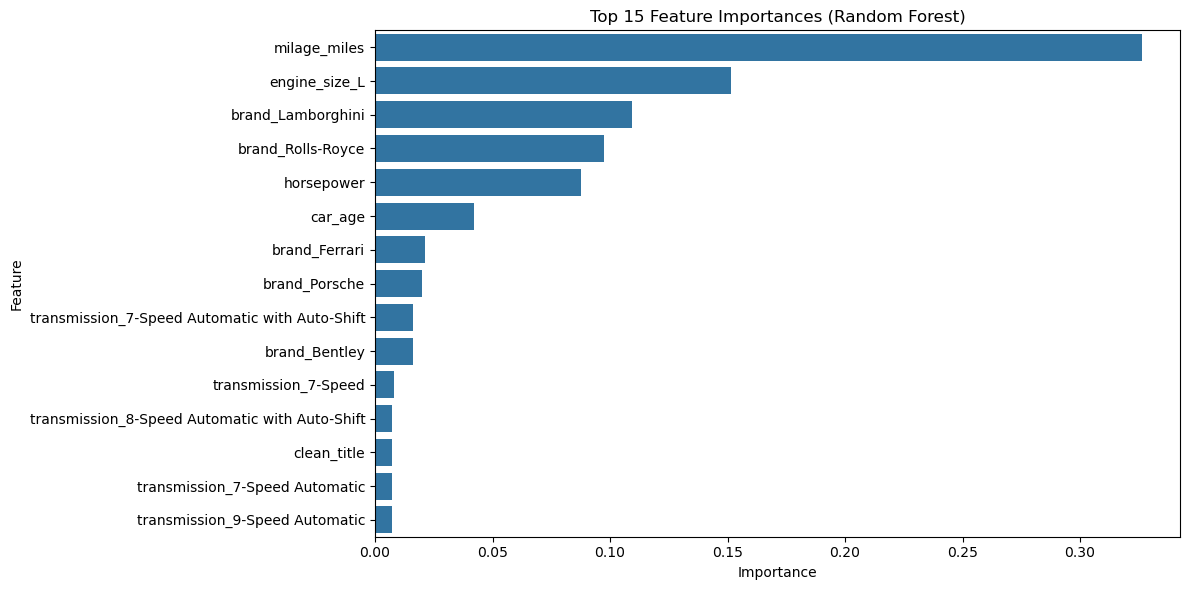

In [319]:
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [321]:
xgb = XGBRegressor(n_estimators = 100, random_state=42)
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [325]:
xgb_importances = xgb.feature_importances_
xgb_feature_names = X.columns

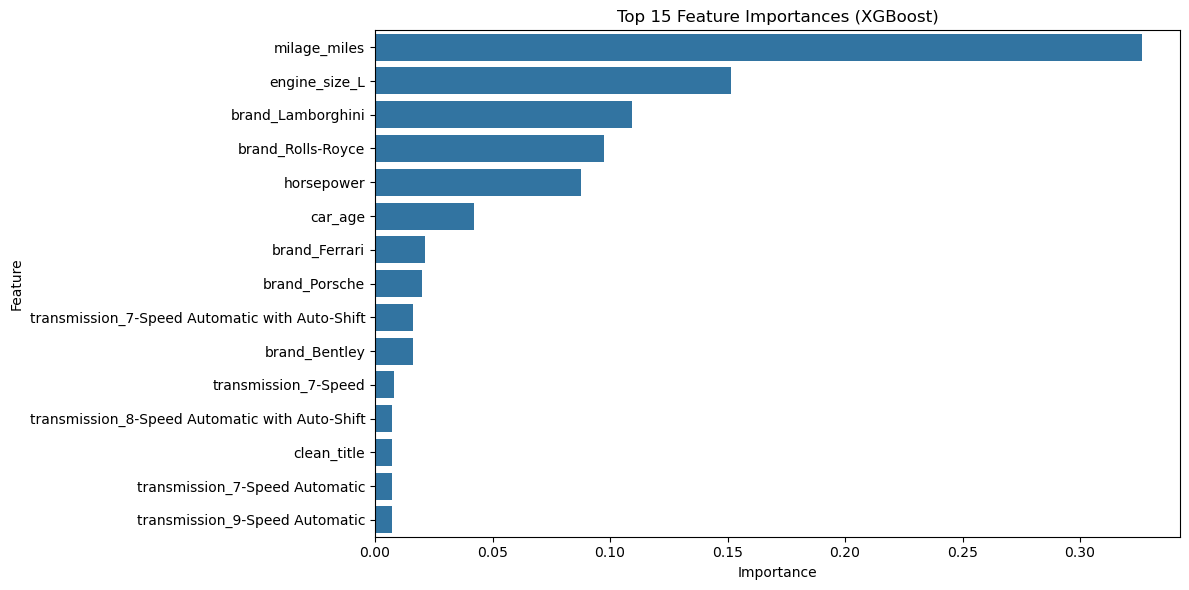

In [333]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df.head(15))
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()